In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas_datareader.data as pdr
import datetime

In [3]:
start_date = datetime.datetime(2011, 1, 1)
end_date = datetime.datetime(2021, 6, 1)

In [4]:
# us and japan cpi
us_cpi = pdr.DataReader("CPIAUCSL", "fred", start_date, end_date)

In [5]:
jp_cpi = pdr.DataReader("JPNCPIALLMINMEI", "fred", start_date, end_date)
jp_cpi

,JPNCPIALLMINMEI
DATE,
2011-01-01,96.10588
2011-02-01,96.10588
2011-03-01,96.30949
2011-04-01,96.41130
2011-05-01,96.41130
...,...
2021-02-01,101.60350
2021-03-01,101.70530
2021-04-01,100.89080


In [6]:
us_cpi.isnull().sum() # 데이터 전처리

,0
CPIAUCSL,0


In [7]:
jp_cpi.isnull().sum() # : 결측치 없음 확인 & 애초에 날짜를 기준으로 데이터를 불러왔기에 타입체크x

,0
JPNCPIALLMINMEI,0


In [8]:
us_cpi_yoy = us_cpi.pct_change(12) # cpi에서 inflation rate 구하기 - percentage change 12 months

In [9]:
jp_cpi_yoy = jp_cpi.pct_change(12) # 계절성을 고려해 year over year 전년동월대비

Text(0, 0.5, 'rate')

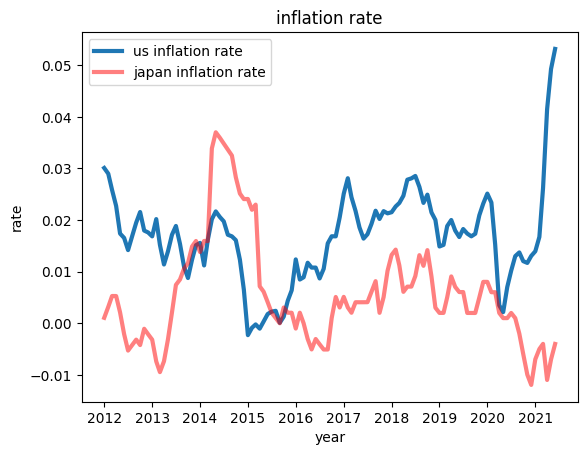

In [10]:
plt.plot(us_cpi_yoy, label = "us inflation rate", linewidth = 3)
plt.plot(jp_cpi_yoy, label = "japan inflation rate", c = "r", linewidth = 3, alpha = 0.5) # alpha = opacity
plt.legend()
plt.title("inflation rate")
plt.xlabel("year")
plt.ylabel("rate")

In [11]:
us_cpi.columns

Index(['CPIAUCSL'], dtype='object')

In [12]:
jp_cpi.columns

Index(['JPNCPIALLMINMEI'], dtype='object')

In [13]:
# absolute PPP
jp_usd_cpi = us_cpi["CPIAUCSL"] / jp_cpi["JPNCPIALLMINMEI"]

In [14]:
jp_usd_cpi.head()

,0
DATE,
2011-01-01,2.301493
2011-02-01,2.308891
2011-03-01,2.315930
2011-04-01,2.324344
2011-05-01,2.331739


In [15]:
# Yen to us dollar spot exchange rate
exchange_yen_usd = pdr.DataReader("DEXJPUS", "fred", start_date, end_date)
exchange_yen_usd.head()

,DEXJPUS
DATE,
2011-01-03,81.56
2011-01-04,81.96
2011-01-05,83.22
2011-01-06,83.15
2011-01-07,83.04


Text(0.5, 1.0, 'Absolute PPP between dollar and yen')

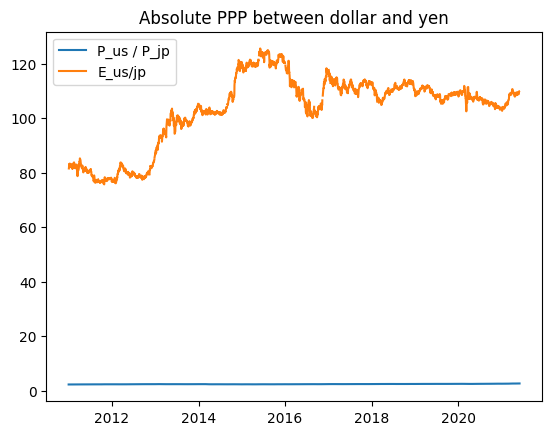

In [16]:
plt.plot(jp_usd_cpi, label = "P_us / P_jp")
plt.plot(exchange_yen_usd, label = "E_us/jp")
plt.legend()
plt.title("Absolute PPP between dollar and yen")
# 차이가 너무 크다

In [17]:
# relative PPP
growth_exchange_yen = exchange_yen_usd.pct_change(12)

<ipython-input-17-1ac4c9bd8554>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  growth_exchange_yen = exchange_yen_usd.pct_change(12)


In [18]:
diff_inflation_rate = us_cpi_yoy["CPIAUCSL"] - jp_cpi_yoy["JPNCPIALLMINMEI"]

In [19]:
diff_inflation_rate.tail()

,0
DATE,
2021-02-01,0.021714
2021-03-01,0.030174
2021-04-01,0.052466
2021-05-01,0.056257
2021-06-01,0.057156


Text(0.5, 1.0, 'relative PPP')

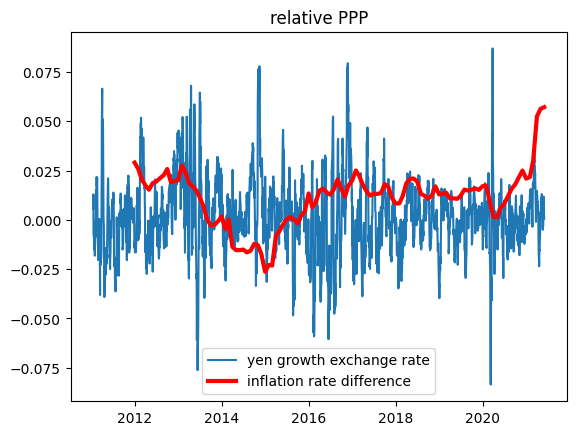

In [20]:
plt.plot(growth_exchange_yen, label = "yen growth exchange rate")
plt.plot(diff_inflation_rate, label = "inflation rate difference",c = "r", linewidth = 3)
plt.legend()
plt.title("relative PPP")
# 전년대비이기에 diff 앞의 1년은 그려지지 않음
# 두 그래프가 같이 간다는 느낌은 없다.
# 환율의 daily 변동성이 더 크다.

In [21]:
# 스무딩해서 다시 그려보겠다
monthly_diff = diff_inflation_rate.resample(rule = "M").mean()

<ipython-input-21-d143ca56a889>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_diff = diff_inflation_rate.resample(rule = "M").mean()


In [22]:
monthly_diff.head()

,0
DATE,
2011-01-31,NaN
2011-02-28,NaN
2011-03-31,NaN
2011-04-30,NaN
2011-05-31,NaN


<Axes: xlabel='DATE'>

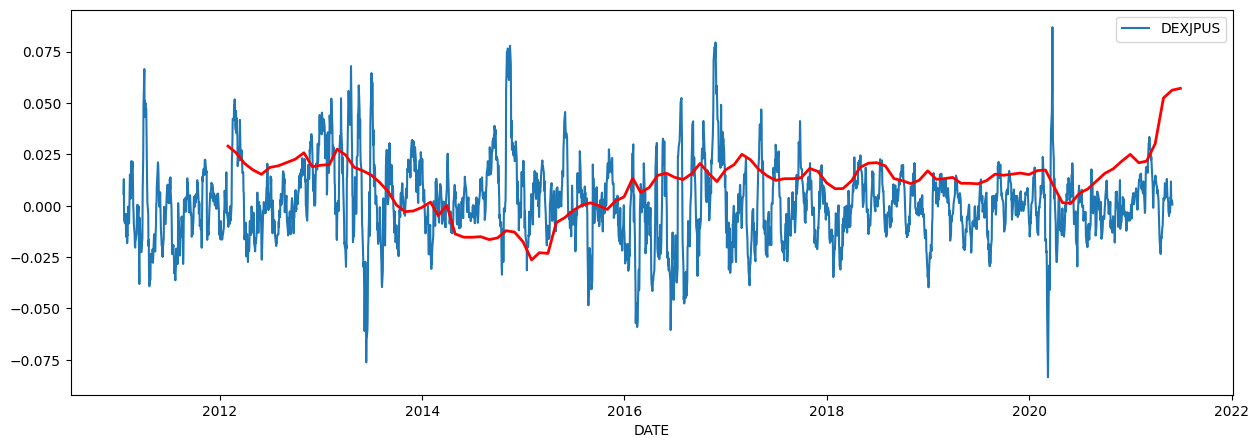

In [23]:
plt.figure(figsize = (15, 5))
sns.lineplot(growth_exchange_yen)
sns.lineplot(monthly_diff, c = "r", linewidth = 2) # yearly는 너무 커서 monthly로

<Axes: xlabel='DATE'>

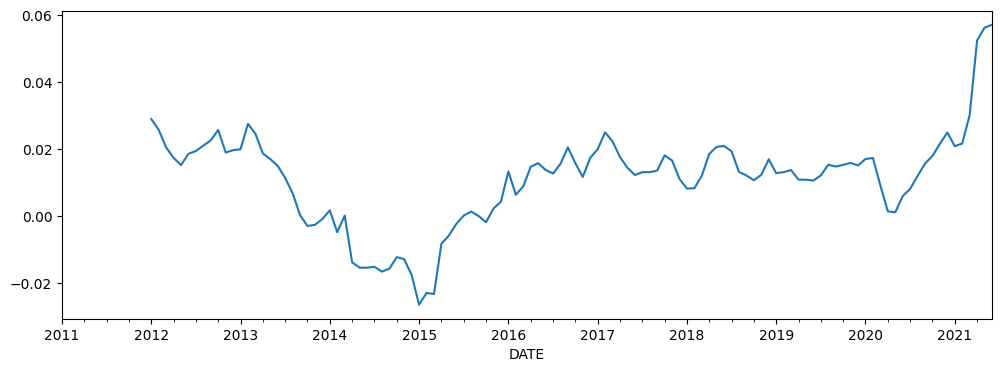

In [24]:
plt.figure(figsize = (12, 4))
diff_inflation_rate.plot() # 솔직히 계절성이 없다고 봐야할것같다.

In [25]:
# autocorrelation plot
from pandas.plotting import lag_plot, autocorrelation_plot

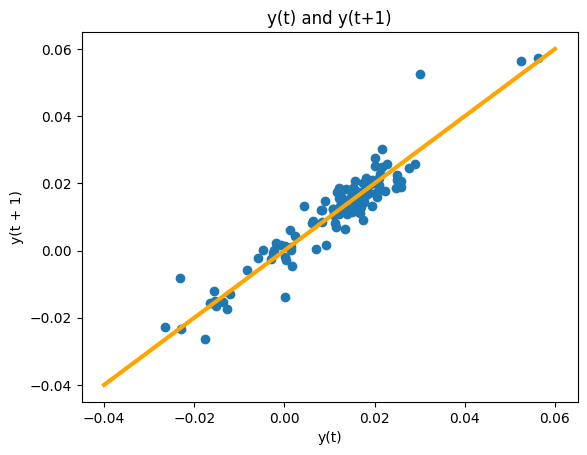

In [26]:
lag_plot(diff_inflation_rate) # positive한 영향. 우상향함.
plt.title("y(t) and y(t+1)")
plt.plot([-0.04, 0.06], [-0.04, 0.06], c = "orange", linewidth = 3) # 0, 30 0, 30 직선 그래프
# 데이터가 적어서 그런가

In [27]:
df = us_cpi_yoy["CPIAUCSL"] - jp_cpi_yoy["JPNCPIALLMINMEI"]

In [28]:
#df.rename(columns = {"0" : "rate"}, inplace = True)
#df.tail()

In [29]:
#df["lag_1"] = df[0].shift(1) # lag를 보자

In [30]:
# 인플레이션 차이를 DataFrame으로 변환
df = pd.DataFrame(us_cpi_yoy["CPIAUCSL"] - jp_cpi_yoy["JPNCPIALLMINMEI"], columns=["diff"])
# lag 값 추가
df["lag_1"] = df["diff"].shift(1)
df.tail()

,diff,lag_1
DATE,,
2021-02-01,0.021714,0.020916
2021-03-01,0.030174,0.021714
2021-04-01,0.052466,0.030174
2021-05-01,0.056257,0.052466
2021-06-01,0.057156,0.056257


In [31]:
df.corr() # 0.94 굉장히 높은데???

,diff,lag_1
diff,1.000000,0.945426
lag_1,0.945426,1.000000


<Axes: >

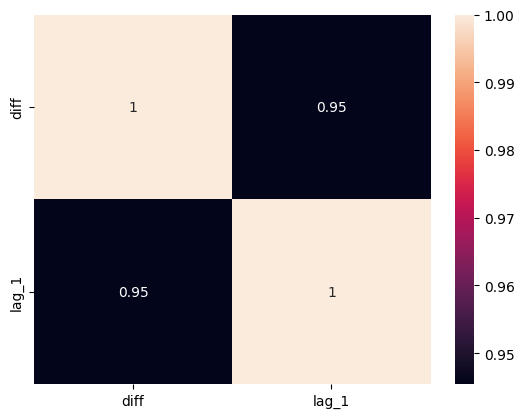

In [32]:
sns.heatmap(df.corr(), annot = True)

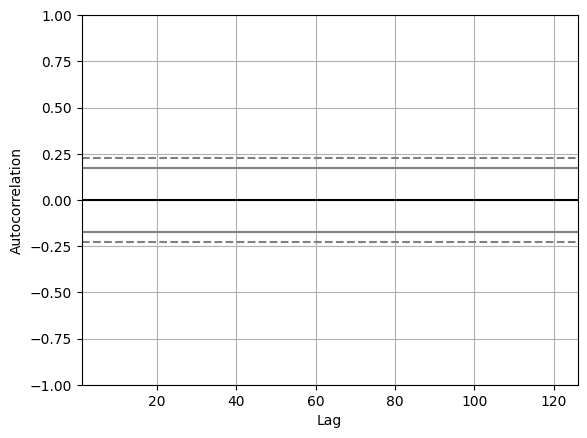

In [33]:
autocorrelation_plot(df["diff"])
plt.show() # 데이터가 너무 적은가

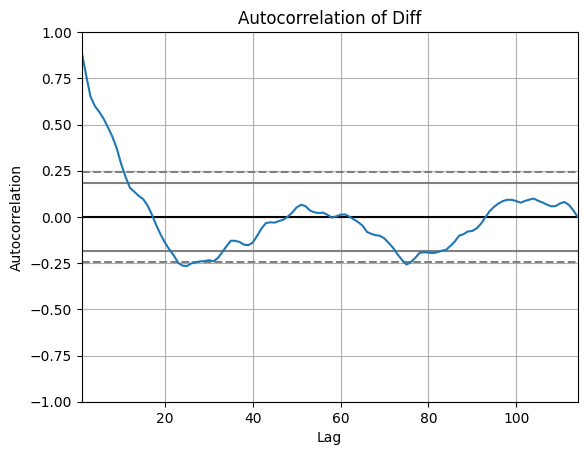

In [34]:
# 결측치 제거
cleaned_data = df["diff"].dropna()

# Autocorrelation Plot
autocorrelation_plot(cleaned_data)
plt.title("Autocorrelation of Diff")
plt.show() # 20언저리를 지나면 거의 미치지 않는다

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

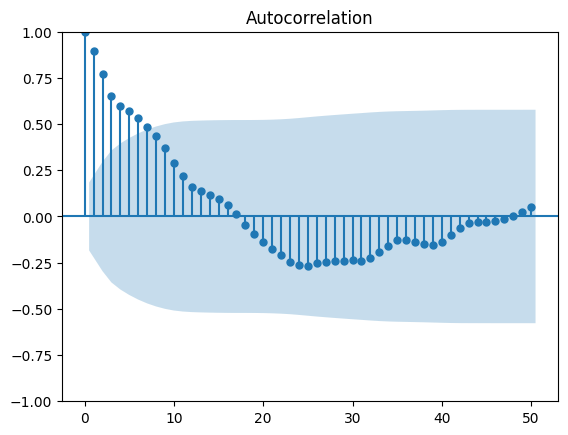

In [36]:
plot_acf(cleaned_data, lags = 50)
plt.show() # ummm
# 처음에는 상관계수가 굉장히 강했다가 급격하게 영향을 미치지 않게됨. 파란 음영을 벗어난 부분도 초기뿐...
# 따라서 lag가 급격히 감소하는 모습을 볼 수 있다.

In [37]:
# stationary한지 ad fuller test 로 검증
from statsmodels.tsa.stattools import adfuller

In [38]:
adfuller(cleaned_data)

(-1.549141533311955,
 0.5090769829886785,
 13,
 100,
 {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349},
 -795.2619719351836)

기각역 = -1.55
5%는 -2.89
-1.55 < -2.89 여야하지만 아니므로 귀무가설 stationary하지 않다를 기각.

In [39]:
#####

In [40]:
######

In [41]:
#

In [42]:
#

프린트








프린트